# Linear regression

In [1]:
# exercise 8.1.1

from matplotlib.pylab import (figure, semilogx, loglog, xlabel, ylabel, legend, 
                           title, subplot, show, grid)
import numpy as np
from scipy.io import loadmat
import sklearn.linear_model as lm
from sklearn import model_selection
from toolbox_02450 import rlr_validate

mat_data = loadmat('./data/body.mat')
X = mat_data['X']
y = mat_data['y'].squeeze()
attributeNames = [name[0] for name in mat_data['attributeNames'][0]]
N, M = X.shape

# Add offset attribute
X = np.concatenate((np.ones((X.shape[0],1)),X),1)
attributeNames = [u'Offset']+attributeNames
M = M+1

## Crossvalidation
# Create crossvalidation partition for evaluation
K = 5
CV = model_selection.KFold(K, shuffle=True)
#CV = model_selection.KFold(K, shuffle=False)

# Values of lambda
lambdas = np.power(10.,range(-5,9))

# Initialize variables
#T = len(lambdas)
Error_train = np.empty((K,1))
Error_test = np.empty((K,1))
Error_train_rlr = np.empty((K,1))
Error_test_rlr = np.empty((K,1))
Error_train_nofeatures = np.empty((K,1))
Error_test_nofeatures = np.empty((K,1))
w_rlr = np.empty((M,K))
mu = np.empty((K, M-1))
sigma = np.empty((K, M-1))
w_noreg = np.empty((M,K))

k=0
for train_index, test_index in CV.split(X,y):
    
    # extract training and test set for current CV fold
    X_train = X[train_index]
    y_train = y[train_index]
    X_test = X[test_index]
    y_test = y[test_index]
    internal_cross_validation = 10    
    
    opt_val_err, opt_lambda, mean_w_vs_lambda, train_err_vs_lambda, test_err_vs_lambda = rlr_validate(X_train, y_train, lambdas, internal_cross_validation)

    # Standardize outer fold based on training set, and save the mean and standard
    # deviations since they're part of the model (they would be needed for
    # making new predictions) - for brevity we won't always store these in the scripts
    mu[k, :] = np.mean(X_train[:, 1:], 0)
    sigma[k, :] = np.std(X_train[:, 1:], 0)
    
    X_train[:, 1:] = (X_train[:, 1:] - mu[k, :] ) / sigma[k, :] 
    X_test[:, 1:] = (X_test[:, 1:] - mu[k, :] ) / sigma[k, :] 
    
    Xty = X_train.T @ y_train
    XtX = X_train.T @ X_train
    
    # Compute mean squared error without using the input data at all
    Error_train_nofeatures[k] = np.square(y_train-y_train.mean()).sum(axis=0)/y_train.shape[0]
    Error_test_nofeatures[k] = np.square(y_test-y_test.mean()).sum(axis=0)/y_test.shape[0]

    # Estimate weights for the optimal value of lambda, on entire training set
    lambdaI = opt_lambda * np.eye(M)
    lambdaI[0,0] = 0 # Do no regularize the bias term
    w_rlr[:,k] = np.linalg.solve(XtX+lambdaI,Xty).squeeze()
    # Compute mean squared error with regularization with optimal lambda
    Error_train_rlr[k] = np.square(y_train-X_train @ w_rlr[:,k]).sum(axis=0)/y_train.shape[0]
    Error_test_rlr[k] = np.square(y_test-X_test @ w_rlr[:,k]).sum(axis=0)/y_test.shape[0]

    # Estimate weights for unregularized linear regression, on entire training set
    w_noreg[:,k] = np.linalg.solve(XtX,Xty).squeeze()
    # Compute mean squared error without regularization
    Error_train[k] = np.square(y_train-X_train @ w_noreg[:,k]).sum(axis=0)/y_train.shape[0]
    Error_test[k] = np.square(y_test-X_test @ w_noreg[:,k]).sum(axis=0)/y_test.shape[0]
    # OR ALTERNATIVELY: you can use sklearn.linear_model module for linear regression:
    #m = lm.LinearRegression().fit(X_train, y_train)
    #Error_train[k] = np.square(y_train-m.predict(X_train)).sum()/y_train.shape[0]
    #Error_test[k] = np.square(y_test-m.predict(X_test)).sum()/y_test.shape[0]

    # Display the results for the last cross-validation fold
    if k == K-1:
        figure(k, figsize=(12,8))
        subplot(1,2,1)
        semilogx(lambdas,mean_w_vs_lambda.T[:,1:],'.-') # Don't plot the bias term
        xlabel('Regularization factor')
        ylabel('Mean Coefficient Values')
        grid()
        # You can choose to display the legend, but it's omitted for a cleaner 
        # plot, since there are many attributes
        #legend(attributeNames[1:], loc='best')
        
        subplot(1,2,2)
        title('Optimal lambda: 1e{0}'.format(np.log10(opt_lambda)))
        loglog(lambdas,train_err_vs_lambda.T,'b.-',lambdas,test_err_vs_lambda.T,'r.-')
        xlabel('Regularization factor')
        ylabel('Squared error (crossvalidation)')
        legend(['Train error','Validation error'])
        grid()
    
    # To inspect the used indices, use these print statements
    #print('Cross validation fold {0}/{1}:'.format(k+1,K))
    #print('Train indices: {0}'.format(train_index))
    #print('Test indices: {0}\n'.format(test_index))

    k+=1

show()
# Display results
print('Linear regression without feature selection:')
print('- Training error: {0}'.format(Error_train.mean()))
print('- Test error:     {0}'.format(Error_test.mean()))
print('- R^2 train:     {0}'.format((Error_train_nofeatures.sum()-Error_train.sum())/Error_train_nofeatures.sum()))
print('- R^2 test:     {0}\n'.format((Error_test_nofeatures.sum()-Error_test.sum())/Error_test_nofeatures.sum()))
print('Regularized linear regression:')
print('- Training error: {0}'.format(Error_train_rlr.mean()))
print('- Test error:     {0}'.format(Error_test_rlr.mean()))
print('- R^2 train:     {0}'.format((Error_train_nofeatures.sum()-Error_train_rlr.sum())/Error_train_nofeatures.sum()))
print('- R^2 test:     {0}\n'.format((Error_test_nofeatures.sum()-Error_test_rlr.sum())/Error_test_nofeatures.sum()))

print('Weights in last fold:')
for m in range(M):
    print('{:>15} {:>15}'.format(attributeNames[m], np.round(w_rlr[m,-1],2)))

print('Ran Exercise 8.1.1')

<Figure size 1200x800 with 2 Axes>

Linear regression without feature selection:
- Training error: 3.345443399442879e-26
- Test error:     76.8686555217962
- R^2 train:     1.0
- R^2 test:     -0.3813937972593797

Regularized linear regression:
- Training error: 1.5416660942033908
- Test error:     5.839081187926331
- R^2 train:     0.9777026692460649
- R^2 test:     0.8950668451276838

Weights in last fold:
         Offset           77.09
     biacromial            0.25
 pelvic.breadth           -0.87
 bitrochanteric           -0.58
    chest.depth            -0.2
     chest.diam           -0.24
     elbow.diam            0.49
     wrist.diam           -0.37
      knee.diam            0.97
     ankle.diam            1.16
 shoulder.girth            0.61
    chest.girth            0.04
    waist.girth            1.53
    navel.girth            0.66
      hip.girth            1.54
    thigh.girth             1.5
    bicep.girth            0.21
  forearm.girth            0.53
     knee.girth            0.69
     calf.girth 

# Logistic regression 

D:\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
D:\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
D:\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
D:\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
D:\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
D:\Anaconda3\lib\site-packages

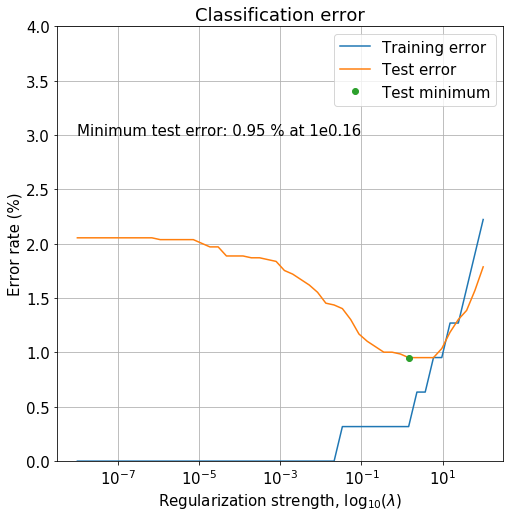

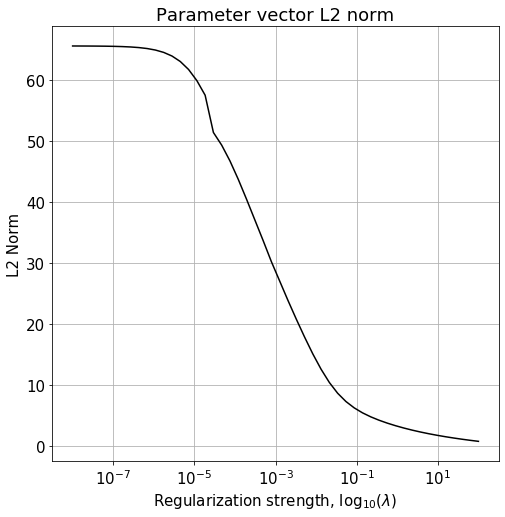

Ran Exercise 9.1.1


In [3]:
# exercise 8.1.2

import matplotlib.pyplot as plt
import numpy as np
from scipy.io import loadmat
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from toolbox_02450 import rocplot, confmatplot


font_size = 15
plt.rcParams.update({'font.size': font_size})

# Load Matlab data file and extract variables of interest
mat_data = loadmat('./data/wine2.mat')
X = mat_data['X']
y = mat_data['y'].squeeze()
attributeNames = [name[0] for name in mat_data['attributeNames'][0]]
classNames = [name[0][0] for name in mat_data['classNames']]
N, M = X.shape
C = len(classNames)


# Create crossvalidation partition for evaluation
# using stratification and 95 pct. split between training and test 
K = 20
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.95, stratify=y)
# Try to change the test_size to e.g. 50 % and 99 % - how does that change the 
# effect of regularization? How does differetn runs of  test_size=.99 compare 
# to eachother?

# Standardize the training and set set based on training set mean and std
mu = np.mean(X_train, 0)
sigma = np.std(X_train, 0)

X_train = (X_train - mu) / sigma
X_test = (X_test - mu) / sigma

# Fit regularized logistic regression model to training data to predict 
# the type of wine
lambda_interval = np.logspace(-8, 2, 50)
train_error_rate = np.zeros(len(lambda_interval))
test_error_rate = np.zeros(len(lambda_interval))
coefficient_norm = np.zeros(len(lambda_interval))
for k in range(0, len(lambda_interval)):
    mdl = LogisticRegression(penalty='l2', C=1/lambda_interval[k] )
    
    mdl.fit(X_train, y_train)

    y_train_est = mdl.predict(X_train).T
    y_test_est = mdl.predict(X_test).T
    
    train_error_rate[k] = np.sum(y_train_est != y_train) / len(y_train)
    test_error_rate[k] = np.sum(y_test_est != y_test) / len(y_test)

    w_est = mdl.coef_[0] 
    coefficient_norm[k] = np.sqrt(np.sum(w_est**2))

min_error = np.min(test_error_rate)
opt_lambda_idx = np.argmin(test_error_rate)
opt_lambda = lambda_interval[opt_lambda_idx]

plt.figure(figsize=(8,8))
#plt.plot(np.log10(lambda_interval), train_error_rate*100)
#plt.plot(np.log10(lambda_interval), test_error_rate*100)
#plt.plot(np.log10(opt_lambda), min_error*100, 'o')
plt.semilogx(lambda_interval, train_error_rate*100)
plt.semilogx(lambda_interval, test_error_rate*100)
plt.semilogx(opt_lambda, min_error*100, 'o')
plt.text(1e-8, 3, "Minimum test error: " + str(np.round(min_error*100,2)) + ' % at 1e' + str(np.round(np.log10(opt_lambda),2)))
plt.xlabel('Regularization strength, $\log_{10}(\lambda)$')
plt.ylabel('Error rate (%)')
plt.title('Classification error')
plt.legend(['Training error','Test error','Test minimum'],loc='upper right')
plt.ylim([0, 4])
plt.grid()
plt.show()    

plt.figure(figsize=(8,8))
plt.semilogx(lambda_interval, coefficient_norm,'k')
plt.ylabel('L2 Norm')
plt.xlabel('Regularization strength, $\log_{10}(\lambda)$')
plt.title('Parameter vector L2 norm')
plt.grid()
plt.show()    

print('Ran Exercise 9.1.1')